# CHIPseq

## (Chromatin immunoprecipitation sequencing)

The methods for material handling and the wet lab parts of these molecular assays are detailed in previous publications [WHICH ONES?]. We conducted some additional experiments on zebrafish to complement the available dataset. These include replicates for dome, 80% epiboly and 24hpf, as well as H3k27ac assays in ducplicate for the shield and 8 somites stages.

In  total, we have 5 stages in zebrafish: some, shield, 80% epiboly, 8 somites, 24hpf (these are the words i have typed the most in my phd) and three in amphixus: 8hpf, 15hpf, 36hpf.    
After the material is sequences we obtain a .fq file, which contains the raw sequencing reads, a collection of about 49bp long sequences and their sequencing quality scores. To use these we must map them to a reference genome, converting each sequence to its absolute coordinates in the genome. We typically only keep reads that can only be mapped to a single position in the genome in order to avoid conflicts.

---
1. Fuentes, M. et al. Preliminary observations on the spawning conditions of the European amphioxus (Branchiostoma lanceolatum) in captivity. J Exp Zool B Mol Dev Evol 302, 384-391 (2004).
2. Fuentes, M. et al. Insights into spawning behavior and development of the European amphioxus (Branchiostoma lanceolatum). J Exp Zool B Mol Dev Evol 308, 484-493 (2007).

## Data processing
We used the following commands to map our .fq files

    # map to a temporary bam file
    >> bowtie2 -p 12 -x ${GenomeIndex} -U ${fqfile}  --very-sensitive-local |\
        samtools view -Shu - > ${temp_bam}
    
    # Sort, remove duplicates, index
    >> samtools sort -@ 11 ${temp_bam}  |  samtools rmdup -s - - > ${final_bam}
    >> samtools index ${final_bam}
    
The resulting .bam files contain the reads, that were succesfully mapped according to our settings, as positions on the genome. This is in essence the raw signal of each experiment.   
We used these files to detect peaks with the following command

    >> macs2 callpeak -f BAM -g ${genome_size} -p  0.005 -t ${fqfile} \
        -n ${outmputname} --outdir ${outputfolder} 

The macs2 program takes care of estimating an apropriate amount of basepairs to extend each reach, an important factor in this process.  

As a result we obtain a bed file, a set of rows, each describing a genomic region and some scores regarding how sure we are that this is a statistically important peak of the signal.

As a final step, for each developmental level, we merge the peaks from the two respective replicates into one combined file.






<br><br><br><br><br><br><br>

# Further analysis

To better analyze our peaks, we will need some more data and some code:

In [1]:
load_NP = lambda fp: pd.read_csv( fp, sep='\t',header=None)

speciesorder = ['amphioxus','zebrafish']

amphioxus_stages = ['8h','15h','36h']
zebrafish_stages = ['dome','shield','80epi','8som','24h','48h']

In [2]:
def get_widths(f, stage):
    df = load_NP(f(stage))
    return pd.DataFrame((df[2]-df[1]))

def get_masked_widths(f, stage,mask):
    df = load_NP(f(stage))
    ndf = BT().from_dataframe( df.iloc[:,:3] ).subtract(mask).to_dataframe()
    return pd.DataFrame((ndf.end - ndf.start))

def get_masked_genome_coverage(f, stage,mask, effective):
    df = load_NP(f(stage))
    ndf = BT().from_dataframe( df.iloc[:,:3] ).subtract(mask).to_dataframe()
    
    return (ndf.end-ndf.start).sum()*100 / effective

def get_numbers(f, stage):
    return len(load_NP(f(stage)))

# Plots


In [3]:
Fwidth = THESIS_PAGEWIDTH/2
Fheight = THESIS_PAGEWIDTH/2

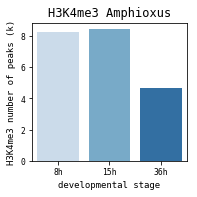

In [4]:
amphi_ef = amphi_k4_005combo
amphi_lot = []
for st in amphioxus_stages:
    ldf = get_numbers(amphi_ef,st)
    amphi_lot.append([st, ldf])
amphi_tp = pd.DataFrame(amphi_lot)  

amphi_tp[1] = amphi_tp[1]/10000

fig, ax = plt.subplots()
fig.subplots_adjust(left=.15, bottom=.15, right=.99, top=.9)
ax.set_title('H3K4me3 Amphioxus')
sns.barplot(data=amphi_tp, x=0,y=1, ax=ax, palette='Blues', )
ax.set_ylabel('H3K4me3 number of peaks (k)')
ax.set_xlabel('developmental stage')
fig.set_size_inches (Fwidth, Fheight)
fig.savefig('../Figures/from_notebooks/tfigure_amphiK4peaks.pdf')

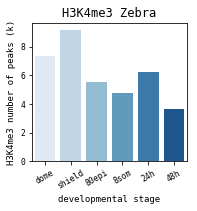

In [5]:
zebra_ef = zebra_k4_005combo
zebra_lot = []
for st in zebrafish_stages:
    ldf = get_numbers(zebra_ef,st)
    zebra_lot.append([st, ldf])
zebra_tp = pd.DataFrame(zebra_lot)
zebra_tp[1] = zebra_tp[1]/10000
fig, ax = plt.subplots()
fig.subplots_adjust(left=.15, bottom=.15, right=.99, top=.9)

sns.barplot(data=zebra_tp, x=0,y=1, ax=ax, palette='Blues', )
ax.set_title('H3K4me3 Zebra')
ax.set_ylabel('H3K4me3 number of peaks (k)')
ax.set_xlabel('developmental stage')
plt.xticks(rotation=30)
fig.set_size_inches (Fwidth, Fheight)
fig.savefig('../Figures/from_notebooks/tfigure_zebraK4peaks.pdf')

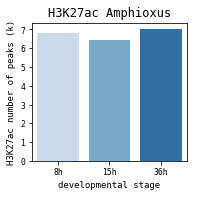

In [6]:
amphi_ef = amphi_k27_005combo
amphi_lot = []
for st in amphioxus_stages:
    ldf = get_numbers(amphi_ef,st)
    amphi_lot.append([st, ldf])
amphi_tp = pd.DataFrame(amphi_lot)  

amphi_tp[1] = amphi_tp[1]/10000
fig, ax = plt.subplots()
fig.subplots_adjust(left=.15, bottom=.15, right=.99, top=.9)
sns.barplot(data=amphi_tp, x=0,y=1, ax=ax, palette='Blues', )
ax.set_title('H3K27ac Amphioxus')
ax.set_ylabel('H3K27ac number of peaks (k)')
ax.set_xlabel('developmental stage')
fig.set_size_inches (Fwidth, Fheight)
fig.savefig('../Figures/from_notebooks/tfigure_amphiK27peaks.pdf')

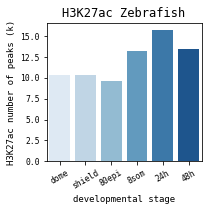

In [7]:
zebra_ef = zebra_k27_005combo
zebra_lot = []
for st in zebrafish_stages:
    ldf = get_numbers(zebra_ef,st)
    zebra_lot.append([st, ldf])
zebra_tp = pd.DataFrame(zebra_lot)  
zebra_tp[1] = zebra_tp[1]/10000

fig, ax = plt.subplots()
fig.subplots_adjust(left=.15, bottom=.15, right=.99, top=.9)
sns.barplot(data=zebra_tp, x=0,y=1, ax=ax, palette='Blues', )
ax.set_title('H3K27ac Zebrafish')
ax.set_ylabel('H3K27ac number of peaks (k)')
ax.set_xlabel('developmental stage')
plt.xticks(rotation=30)
fig.set_size_inches (Fwidth, Fheight)
fig.savefig('../Figures/from_notebooks/tfigure_zebraK27peaks.pdf')

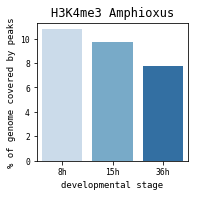

In [8]:
amphi_ef = amphi_k4_005combo
amphi_lot = []
for st in amphioxus_stages:
    ldf = get_masked_genome_coverage(amphi_ef,st, amphi_mask, amphi_effective)
    amphi_lot.append([st, ldf])
amphi_tp = pd.DataFrame(amphi_lot)  

fig, ax = plt.subplots()
fig.subplots_adjust(left=.17, bottom=.15, right=.99, top=.9)
sns.barplot(data=amphi_tp, x=0,y=1, ax=ax, palette='Blues', )
ax.set_title('H3K4me3 Amphioxus')
ax.set_ylabel('% of genome covered by peaks')
ax.set_xlabel('developmental stage')
fig.set_size_inches (Fwidth, Fheight)
fig.savefig('../Figures/from_notebooks/tfigure_amphiK4genomeCoverage.pdf')

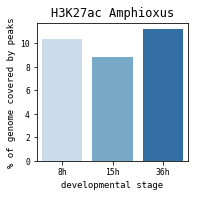

In [9]:
amphi_ef = amphi_k27_005combo
amphi_lot = []
for st in amphioxus_stages:
    ldf = get_masked_genome_coverage(amphi_ef,st, amphi_mask, amphi_effective)
    amphi_lot.append([st, ldf])
amphi_tp = pd.DataFrame(amphi_lot)  

fig, ax = plt.subplots()
fig.subplots_adjust(left=.17, bottom=.15, right=.99, top=.9)
sns.barplot(data=amphi_tp, x=0,y=1, ax=ax, palette='Blues', )
ax.set_title('H3K27ac Amphioxus')
ax.set_ylabel('% of genome covered by peaks')
ax.set_xlabel('developmental stage')
fig.set_size_inches (Fwidth, Fheight)
fig.savefig('../Figures/from_notebooks/tfigure_amphiK27genomeCoverage.pdf')

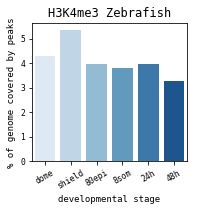

In [10]:
zebra_ef = zebra_k4_005combo
zebra_lot = []
for st in zebrafish_stages:
    ldf = get_masked_genome_coverage(zebra_ef,st, 
                                     zebrafish_mask, zebrafish_effective)
    zebra_lot.append([st, ldf])
zebra_tp = pd.DataFrame(zebra_lot)

fig, ax = plt.subplots()
fig.subplots_adjust(left=.15, bottom=.15, right=.99, top=.9)

sns.barplot(data=zebra_tp, x=0,y=1, ax=ax, palette='Blues', )
ax.set_title('H3K4me3 Zebrafish')
ax.set_ylabel('% of genome covered by peaks')
ax.set_xlabel('developmental stage')
plt.xticks(rotation=30)
fig.set_size_inches (Fwidth, Fheight)
fig.savefig('../Figures/from_notebooks/tfigure_zebraK4genomeCoverage.pdf')

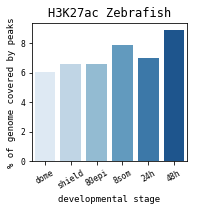

In [11]:
zebra_ef = zebra_k27_005combo
zebra_lot = []
for st in zebrafish_stages:
    ldf = get_masked_genome_coverage(zebra_ef,st, zebrafish_mask,
                                     zebrafish_effective)
    zebra_lot.append([st, ldf])
zebra_tp = pd.DataFrame(zebra_lot)

fig, ax = plt.subplots()
fig.subplots_adjust(left=.15, bottom=.15, right=.99, top=.9)
sns.barplot(data=zebra_tp, x=0,y=1, ax=ax, palette='Blues', )
ax.set_title('H3K27ac Zebrafish')
ax.set_ylabel('% of genome covered by peaks')
ax.set_xlabel('developmental stage')
plt.xticks(rotation=30)
fig.set_size_inches (Fwidth, Fheight)
fig.savefig('../Figures/from_notebooks/tfigure_zebraK27genomeCoverage.pdf')

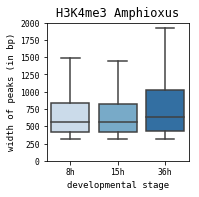

In [12]:
amphi_ef = amphi_k4_005combo
amphi_lot = []
for st in amphioxus_stages:
    ldf = get_widths(amphi_ef,st)
    ldf['stage'] = st
    amphi_lot.append(ldf)
amphi_tp = pd.concat(amphi_lot)  

fig, ax = plt.subplots()
fig.subplots_adjust(left=.22, bottom=.15, right=.99, top=.9)
sns.boxplot(data=amphi_tp, x='stage',y=0, ax=ax, palette='Blues',
                                                    fliersize=0)
plt.ylim((0,2000))
ax.set_title('H3K4me3 Amphioxus')
ax.set_ylabel('width of peaks (in bp)')
ax.set_xlabel('developmental stage')
fig.set_size_inches (Fwidth, Fheight)
fig.savefig('../Figures/from_notebooks/tfigure_amphiK4peakwidth.pdf')

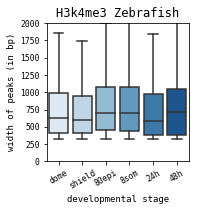

In [13]:
zebra_ef = zebra_k4_005combo
zebra_lot = []
for st in zebrafish_stages:
    ldf = get_widths(zebra_ef,st)
    ldf['stage'] = st
    zebra_lot.append(ldf)
zebra_tp = pd.concat(zebra_lot)  

fig, ax = plt.subplots()
fig.subplots_adjust(left=.22, bottom=.15, right=.99, top=.9)
sns.boxplot(data=zebra_tp, x='stage',y=0, ax=ax, palette='Blues',
                                                    fliersize=0)
plt.ylim((0,2000))
ax.set_title('H3k4me3 Zebrafish')
ax.set_ylabel('width of peaks (in bp)')
ax.set_xlabel('developmental stage')
plt.xticks(rotation=30)
fig.set_size_inches (Fwidth, Fheight)
fig.savefig('../Figures/from_notebooks/tfigure_zebraK4peakwidth.pdf')

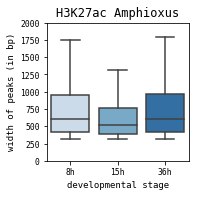

In [14]:
amphi_ef = amphi_k27_005combo
amphi_lot = []
for st in amphioxus_stages:
    ldf = get_widths(amphi_ef,st)
    ldf['stage'] = st
    amphi_lot.append(ldf)
amphi_tp = pd.concat(amphi_lot)  

fig, ax = plt.subplots()
fig.subplots_adjust(left=.22, bottom=.15, right=.99, top=.90)
sns.boxplot(data=amphi_tp, x='stage',y=0, ax=ax, palette='Blues', fliersize=0)
plt.ylim((0,2000))
ax.set_title('H3K27ac Amphioxus')
ax.set_ylabel('width of peaks (in bp)')
ax.set_xlabel('developmental stage')
fig.set_size_inches (Fwidth, Fheight)
fig.savefig('../Figures/from_notebooks/tfigure_amphiK27peakwidth.pdf')

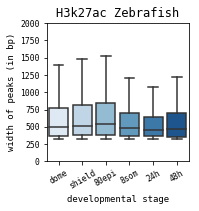

In [15]:
zebra_ef = zebra_k27_005combo
zebra_lot = []
for st in zebrafish_stages:
    ldf = get_widths(zebra_ef,st)
    ldf['stage'] = st
    zebra_lot.append(ldf)
zebra_tp = pd.concat(zebra_lot)  

fig, ax = plt.subplots()
fig.subplots_adjust(left=.22, bottom=.15, right=.99, top=.9)
sns.boxplot(data=zebra_tp, x='stage',y=0, ax=ax, palette='Blues', fliersize=0)
plt.ylim((0,2000))
ax.set_title('H3k27ac Zebrafish')
ax.set_ylabel('width of peaks (in bp)')
ax.set_xlabel('developmental stage')
plt.xticks(rotation=30)
fig.set_size_inches (Fwidth, Fheight)
fig.savefig('../Figures/from_notebooks/tfigure_zebraK27peakwidth.pdf')